In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import math
import time
import random
import subprocess
import tempfile

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
from tqdm import tqdm

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.generator import AdaLead
from boda.generator.energy import OverMaxEnergy, StremePenalty
from boda.common import constants, utils
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [40]:
def align_to_alphabet(in_tensor, in_alphabet=['A','C','G','T'], out_alphabet=constants.STANDARD_NT):
    permuted_idxs = []
    for nt in out_alphabet:
        permuted_idxs.append(in_alphabet.index(nt))
    permutation_idxs = torch.LongTensor(permuted_idxs)
    out_tensor = in_tensor[permutation_idxs, :]
    return out_tensor

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_alphabet=alphabet,  out_alphabet=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def show_streme_motifs(parsed_output, num_motifs=None):
    motif_dict = parsed_output['motif_results']
    results_alphabet = parsed_output['meta_data']['alphabet']
    if not num_motifs:
        Range = len(motif_dict)
    else:
        Range = num_motifs
    for motif_idx in range(Range):
        motif_ppm = torch.tensor((motif_dict[motif_idx]['ppm']))
        motif_ppm = align_to_alphabet(motif_ppm, in_alphabet=results_alphabet)
        motif_ppm_rc = reverse_complement(motif_ppm)
        print(motif_dict[motif_idx]['summary'])
        matrix_to_dms(ppm_to_IC(motif_ppm), y_max=2)
        plt.show()
        matrix_to_dms(ppm_to_IC(motif_ppm_rc), y_max=2)
        plt.show()

### Retreive track info

In [91]:
all_pickle_paths = !gsutil ls $'gs://syrgoth/boda_library_design_202112/extra_pickles_2'
all_pickle_paths = all_pickle_paths[1:]
#all_pickle_paths = [pickle for pickle in all_pickle_paths if ('sa' in pickle) and ('uc' not in pickle)]
all_pickle_paths

['gs://syrgoth/boda_library_design_202112/extra_pickles_2/rc__hepg2__fsp__track_002__round_0__20211212_012620__229779.pt',
 'gs://syrgoth/boda_library_design_202112/extra_pickles_2/rc__hepg2__fsp__track_008__round_5__20211212_045907__313665.pt',
 'gs://syrgoth/boda_library_design_202112/extra_pickles_2/rc__hepg2__fsp__track_009__round_5__20211212_052639__969454.pt',
 'gs://syrgoth/boda_library_design_202112/extra_pickles_2/rc__hepg2__fsp__track_010__round_5__20211212_055149__346635.pt',
 'gs://syrgoth/boda_library_design_202112/extra_pickles_2/rc__hepg2__fsp__track_011__round_5__20211212_061436__944763.pt',
 'gs://syrgoth/boda_library_design_202112/extra_pickles_2/rc__k562__fsp__track_001__round_0__20211212_010357__323391.pt',
 'gs://syrgoth/boda_library_design_202112/extra_pickles_2/rc__k562__fsp__track_004__round_5__20211212_022207__477844.pt',
 'gs://syrgoth/boda_library_design_202112/extra_pickles_2/rc__k562__fsp__track_005__round_5__20211212_024754__730114.pt',
 'gs://syrgoth/boda

In [92]:
penalty_tracks = {}
for file_name in all_pickle_paths:
    info = os.path.basename(file_name)
    user, celltype, generator, track_num, round_num, trak_ID, random_tag = info.split('__')
    if round_num != 'round_0':
        penalty_tracks[trak_ID + '__' + random_tag.rstrip('.pt')] = track_num

In [93]:
penalty_tracks

{'20211212_045907__313665': 'track_008',
 '20211212_052639__969454': 'track_009',
 '20211212_055149__346635': 'track_010',
 '20211212_061436__944763': 'track_011',
 '20211212_022207__477844': 'track_004',
 '20211212_024754__730114': 'track_005',
 '20211212_085225__619474': 'track_006',
 '20211212_092818__893131': 'track_007',
 '20211212_122659__199840': 'track_012',
 '20211212_073316__958155': 'track_013',
 '20211212_075659__621411': 'track_014',
 '20211212_082245__817810': 'track_015'}

In [107]:
all_proposal_dicts = {}
for file_name in tqdm(all_pickle_paths):
    with tempfile.TemporaryDirectory() as tmpdir:
        temp_loc = os.path.join(tmpdir, os.path.basename(file_name)) 
        subprocess.check_call(['gsutil', 'cp', file_name, temp_loc])
        all_proposal_dicts[os.path.basename(file_name).rstrip('.pt')] = torch.load(temp_loc)

100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


---------------- rc__hepg2__fsp__track_008__round_5__20211212_045907__313665 ----------------

-------- Round 1 --------
{'alength': 4, 'w': 15, 'nsites': 404, 'E': 8.1e-15}


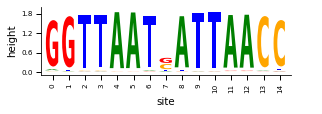

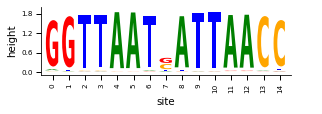

-------- Round 2 --------
{'alength': 4, 'w': 15, 'nsites': 245, 'E': 1.6e-12}


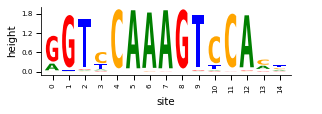

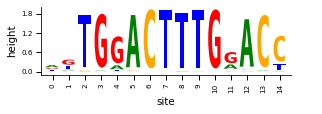

-------- Round 3 --------
{'alength': 4, 'w': 13, 'nsites': 228, 'E': 9.9e-07}


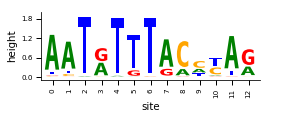

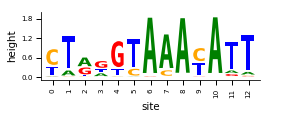

-------- Round 4 --------
{'alength': 4, 'w': 15, 'nsites': 216, 'E': 4.8e-09}


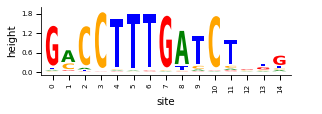

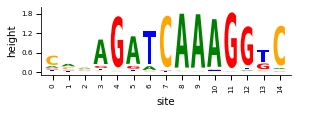

-------- Round 5 --------
{'alength': 4, 'w': 15, 'nsites': 167, 'E': 2.8e-05}


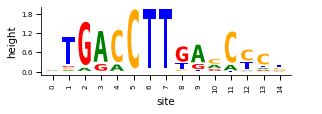

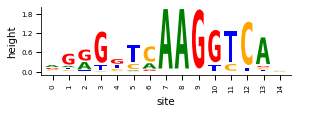


---------------- rc__hepg2__fsp__track_009__round_5__20211212_052639__969454 ----------------

-------- Round 1 --------
{'alength': 4, 'w': 13, 'nsites': 343, 'E': 1.2e-15}


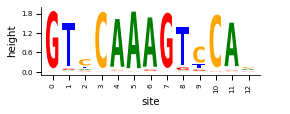

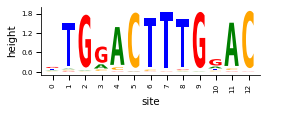

-------- Round 2 --------
{'alength': 4, 'w': 10, 'nsites': 239, 'E': 1.9e-12}


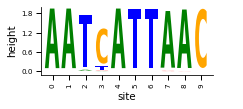

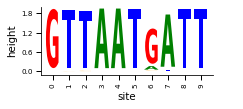

-------- Round 3 --------
{'alength': 4, 'w': 13, 'nsites': 241, 'E': 4e-11}


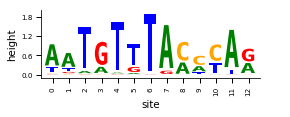

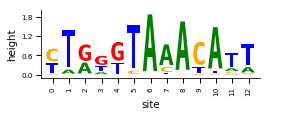

-------- Round 4 --------
{'alength': 4, 'w': 11, 'nsites': 186, 'E': 1.4e-07}


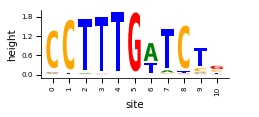

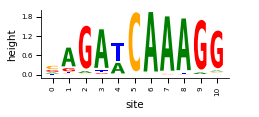

-------- Round 5 --------
{'alength': 4, 'w': 13, 'nsites': 89, 'E': 0.00084}


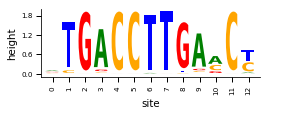

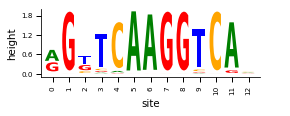


---------------- rc__hepg2__fsp__track_010__round_5__20211212_055149__346635 ----------------

-------- Round 1 --------
{'alength': 4, 'w': 13, 'nsites': 408, 'E': 1.7e-19}


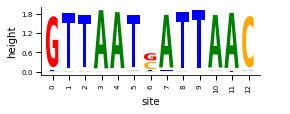

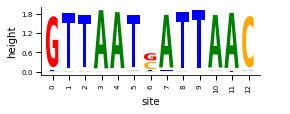

-------- Round 2 --------
{'alength': 4, 'w': 12, 'nsites': 249, 'E': 1.6e-12}


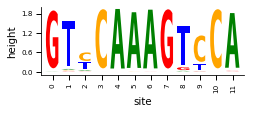

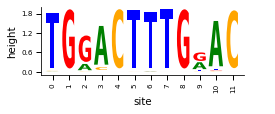

-------- Round 3 --------
{'alength': 4, 'w': 13, 'nsites': 220, 'E': 1.5e-06}


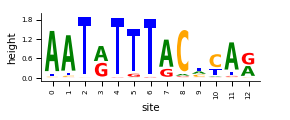

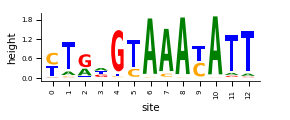

-------- Round 4 --------
{'alength': 4, 'w': 11, 'nsites': 204, 'E': 3.8e-05}


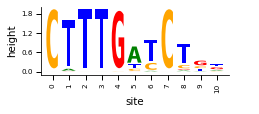

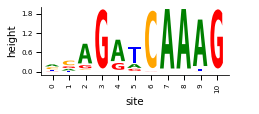

-------- Round 5 --------
{'alength': 4, 'w': 10, 'nsites': 152, 'E': 3.3e-05}


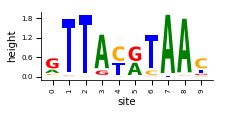

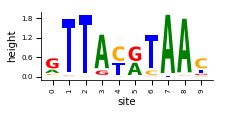


---------------- rc__hepg2__fsp__track_011__round_5__20211212_061436__944763 ----------------

-------- Round 1 --------
{'alength': 4, 'w': 15, 'nsites': 401, 'E': 9e-18}


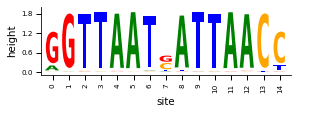

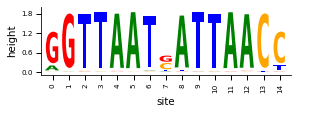

-------- Round 2 --------
{'alength': 4, 'w': 12, 'nsites': 237, 'E': 4.8e-09}


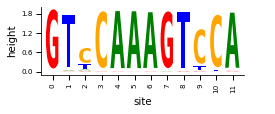

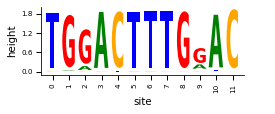

-------- Round 3 --------
{'alength': 4, 'w': 14, 'nsites': 221, 'E': 3.6e-08}


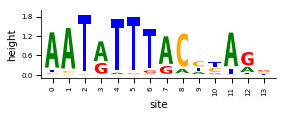

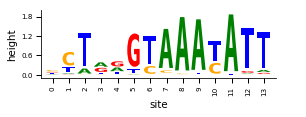

-------- Round 4 --------
{'alength': 4, 'w': 11, 'nsites': 226, 'E': 4.3e-10}


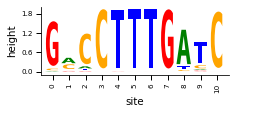

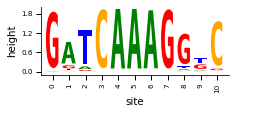

-------- Round 5 --------
{'alength': 4, 'w': 14, 'nsites': 162, 'E': 0.00084}


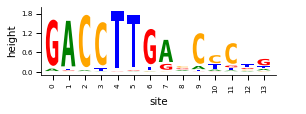

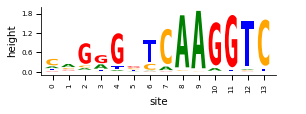

In [141]:
for track in list(all_proposal_dicts.keys())[1:]:
    if 'hepg2' in track:
        print(f'---------------- {track} ----------------')
        print('')
        track_info = all_proposal_dicts[track]['proposals']
        for Round in range(1,len(track_info)):
            print(f'-------- Round {Round} --------')
            streme_results = track_info[Round]['penalty']['streme_output']
            parsed_output = parse_streme_output(streme_results['output'])
            show_streme_motifs(parsed_output, num_motifs=1)
        print('')

In [55]:
batch = all_proposal_dicts['rc__hepg2__fsp__track_009__round_5__20211212_052639__969454']['proposals'][0]['proposals']

In [56]:
batch_size = 5#batch.shape[0]
for seq_idx in range(batch_size):
    seq_tensor = batch[seq_idx, :, :]
    idxs = torch.argmax(seq_tensor, dim=0).numpy()
    sequence_str = ''
    for idx in idxs:
        sequence_str += constants.STANDARD_NT[idx]
    print(sequence_str)

GTGGGAACCATGGTTAATCATTAACCAGGATACCAGGTCAGGTGTCCACAATGTCAGGTAGAGGGTCTGGCAATCCTTAAACCAGGGAGCGGAATGACCTTTGTACTCTCAGGTAACGACATGTCAATGCTTACACAATCAACGCTCTTGTGTACCTTGCCCGGTCTGGACCCTTAGCTCCCACCAAGACAATAGATGGG
GGTGCCAGTGTAGGCGCACTGTCACCCTGGTTAATCATTAACCAAGATCCACGGTGTCGTCGCATCATCAACCAAAGGACACGGGAATACAGAGCGTATTGTGGGCCATTGACCCGTGTACCCCGGTTACTCATTAACCAGGGCATTCACCCAGGAACACAAATAGTGTTGGGCCTTGGGTACCAAGTCCATATGGTTGG
GGTGCCAACCGTCAAGCCTGTCTGGGGCCTGTATCGAAAGTGTCGGTCCAGAGTCCAAAGTCCACCTTGGTTAAACCTACAGCAAATATACCATACTAAACTTGTTTATCAGGTTGACCTTTGCCCCCTAAGATGTGTGATGTGGCATTAGGTTAATCATAAACTAGATAGGGCAGCCGCAACGATGGCACCACAGTTGG
GTCGCGATTCAATGTCCCCAGTGACCTTACACTGGGTGCCAGTCACCTGGTTAATGATTAACTAGGGATGGGGGTCCAAGGGTCACTTTATCAATGATAGCCAGCGCGATACTATATACTGCGGTCGATAATAAGGCAAATGGTTTAAAATTTATATACCTGTGTGCCCATACGCAAATATTGGCACTTTGGACTTTGTA
GGTAGCCCGGTACGGGAACAGCACTTGCACTTTGAACTTTGGACCAATGGAGCTTGGACTTCGTCCCTTAGCTATACTCCAAAGTTCACTGGCGGGCTTTGTACCTAACTGGCACCCCCAGGATCGTCGGGCTCCCTCACAAAACCTCTTGCTAGACTCTAAGTAAACCAGGGCATTAATGGGTACAAAGTCCAAA

In [138]:
%%time 
folder_name = 'streme_penalty_dicts'
for track in list(all_proposal_dicts.keys()): 
    track_info = all_proposal_dicts[track]['proposals']
    for Round in range(1,len(track_info)):        
        streme_results = track_info[Round]['penalty']['streme_output']
        parsed_output = parse_streme_output(streme_results['output'])
        if streme_results:
            user, celltype, generator, track_num, round_num, track_ID, random_tag = track.split('__')
            dict_name = f'streme_penalty__{generator}__{celltype}__{track_ID}__' + random_tag.rstrip('.pt') + f'__round_{Round}.pt' 
            save_path = f'{folder_name}/{dict_name}'
            print(save_path)
            #torch.save(parsed_output, save_path)
#             if Round == 1:
#                 print(f'---------------- {track} ----------------')
#                 print('')
#             print(f'-------- Round {Round} --------')
#             print(streme_results.keys())
    print('')


streme_penalty_dicts/streme_penalty__fsp__hepg2__20211212_045907__313665__round_1.pt
streme_penalty_dicts/streme_penalty__fsp__hepg2__20211212_045907__313665__round_2.pt
streme_penalty_dicts/streme_penalty__fsp__hepg2__20211212_045907__313665__round_3.pt
streme_penalty_dicts/streme_penalty__fsp__hepg2__20211212_045907__313665__round_4.pt
streme_penalty_dicts/streme_penalty__fsp__hepg2__20211212_045907__313665__round_5.pt

streme_penalty_dicts/streme_penalty__fsp__hepg2__20211212_052639__969454__round_1.pt
streme_penalty_dicts/streme_penalty__fsp__hepg2__20211212_052639__969454__round_2.pt
streme_penalty_dicts/streme_penalty__fsp__hepg2__20211212_052639__969454__round_3.pt
streme_penalty_dicts/streme_penalty__fsp__hepg2__20211212_052639__969454__round_4.pt
streme_penalty_dicts/streme_penalty__fsp__hepg2__20211212_052639__969454__round_5.pt

streme_penalty_dicts/streme_penalty__fsp__hepg2__20211212_055149__346635__round_1.pt
streme_penalty_dicts/streme_penalty__fsp__hepg2__20211212_0551

In [139]:
import shutil
shutil.make_archive('fsp_streme_dicts', 'zip', 'streme_penalty_dicts')

'/home/ubuntu/boda2/analysis/RC20_MPRA_BODA2_analysis/fsp_streme_dicts.zip'

In [140]:
streme_results

{'output': b'********************************************************************************\nSTREME - Sensitive, Thorough, Rapid, Enriched Motif Elicitation\n********************************************************************************\nMEME version 5.4.0 (Release date: Sat Aug 21 19:23:23 2021 -0700)\n\nFor further information on how to interpret these results please access https://meme-suite.org/meme.\nTo get a copy of the MEME Suite software please access https://meme-suite.org.\n\n********************************************************************************\n\n\n********************************************************************************\nREFERENCE\n********************************************************************************\nIf you use this program in your research, please cite:\n\nTimothy L. Bailey,\n"STREME: accurate and versatile sequence motif discovery",\nBioinformatics, Mar. 24, 2021.\n**************************************************************************